In [ ]:
using Gadfly
using Colors
#set_default_plot_size(25cm, 8cm)

# Parameter Estimation in a Cascading Latent Force Model

### Example: brine tank cascade

(see [here](./Cascading%20Latent%20Force%20Model.ipynb) for model set-up and inference, [model reference](http://www.math.utah.edu/~gustafso/2250systems-de.pdf))

```
    ↓ ___
   | (1) |__
   |_______↴|____
        |        |___
        |  (2)    __↴|_________
        |________| |           |
                   |   (3)     |
                   |_____     _|
                         | ↓ |
```

The system is modelled as a joint Gaussian distribution, giving the following single latent force model:

$$
    \frac{\mathrm{d}}{\mathrm{d}t}\mathbf{f}(t) = \mathbf{A}\mathbf{f}(t) + \mathbf{L}u(t)
$$
$$
    y(t) = \mathbf{H}\mathbf{f}(t) + \nu(t)
$$

Where 

$$ \mathbf{f}(t) = \begin{bmatrix}f_1(t)\\ f_2(t)\\ f_3(t)\end{bmatrix}, \qquad
    \mathbf{A} = \begin{bmatrix}
        a_1 & 0 & 0 \\
        -a_1 & a_2 & 0 \\ 
        0 & -a_2 & a_3
    \end{bmatrix}, \qquad \mathbf{L} = \begin{bmatrix}1 \\ 0 \\ 0\end{bmatrix}
$$

$$
    \mathbf{H} = \begin{bmatrix}0 & 0 & -a_3\end{bmatrix}
$$

## Modelling

This is based on the Cascading Latent Force Model example, with scripts in `CLFM_demo.jl`

In [128]:
include("CLFM_demo.jl")

params = default_params()

#= This is equiv, with default params:
y = generate_observations(ts)
f, P = infer(t,y,ts)
=#
df = demo(𝛉=params, as_dataframe=:true)

head(df)

6×6 DataFrames.DataFrame. Omitted printing of 6 columns
│ Row │ ├─────┼
│ 1   │ │ 2   │ │ 3   │ │ 4   │ │ 5   │ │ 6   │

### Plot system variables and latent force posterior

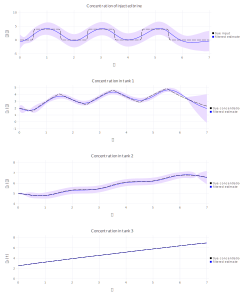

In [274]:
set_default_plot_size(24cm, 30cm)
plot_estimate(df[:mean], df[:cov], df[:t], 𝛉=params)

# This is also saved to file by demo() 
#=
open("CLFM_demo_smoothed.svg") do f
    display("image/svg+xml", readstring(f))
end
=#

## Parameter Estimation

Use particle Gibbs to estimate parameters, first of GP kernel, i.e. $\mathscr{l}$ and $\sigma_\kappa^2$, then include system parameters

In [16]:
using Turing
using Mamba: describe, plot

We generate some observations, using the default parameters

In [276]:
θ = default_params(as_dict=true)

nₜ = 1000
t  = linspace(0., 7., nₜ)
ix = 1:10:nₜ

𝐲 = generate_observations(t[ix], 𝛉 = θ);

Turing models used here. Put Inverse Gamma priors over variables -- _not sure if this is right_

Likelihood is a multivariate normal over the observations, with mean and cov output from KF/RTS in obs space.

Also don't get full covariance of likelihood, only diagonal (not sure if important, implementation slow / not working).

In [277]:
@model clfm_known_rate(y) = begin
    
    l  ~ InverseGamma(2, 0.5)
    σ² ~ InverseGamma(2, 4)
    
    θ = default_params(as_dict=true)
    
    θ["Kernel Parameters"] = (√3/l, l, σ²)
    
    f, P, _, _, G = infer(t, y, t[ix], 𝛉=θ, rts=:true, gain=:true)
    
    #y ~ likelihood(f[ix], P[ix], 𝐆=G[ix], 𝛉 = θ) #mvnormal
    y ~ likelihood(f[ix], P[ix], 𝛉 = θ, noiseless=:false) #mvnormal
    
    return l, σ², a₁, a₂, a₃
end

@model clfm_unknown_rate(y) = begin
    l  ~ InverseGamma(2, 0.5)
    σ² ~ InverseGamma(2, 4)
    a₁ ~ InverseGamma(2, 0.5)
    a₂ ~ InverseGamma(2, 0.25)
    a₃ ~ InverseGamma(2, 0.125)
    
    θ = default_params(as_dict=true)
    
    θ["Output Rates"] = (-a₁, -a₂, -a₃)
    θ["Kernel Parameters"] = (√3/l, l, σ²)
    
    
    f, P, _, _, G = infer(t, y, t[ix], 𝛉=θ, rts=:true, gain=:true)
    
    
    #y ~ likelihood(f[ix], P[ix], 𝐆=G[ix], 𝛉 = θ) #mvnormal
    y ~ likelihood(f[ix], P[ix], 𝛉 = θ, noiseless=:false) #mvnormal
    
    return l, σ², a₁, a₂, a₃
end

clfm_unknown_rate (generic function with 2 methods)

In [278]:
c1 = sample(clfm_known_rate(𝐲), PG(25, 1000))

[Turing]:  Assume - `l` is a parameter (ignoring `l` found in global scope)
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `σ²` is a parameter (ignoring `σ²` found in global scope)
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Observe - `y` is an observation
 @~(::ANY, ::ANY) at compiler.jl:57


[PG] Sampling...100%  ETA: 0:00:01

Object of type "Turing.Chain"

Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

[0.329666 0.499222 5.5548 0.0; 0.233964 0.563923 4.1968 0.0; … ; 0.148978 0.340397 4.46248 0.0; 0.227218 0.501471 3.93057 0.0]

In [279]:
describe(c1)

[PG] Finished with
  Running time    = 472.01216417899974;


[PG] Sampling...100% Time: 0:07:52


Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

Empirical Posterior Estimates:
            Mean         SD       Naive SE       MCSE        ESS  
      l  0.26443021  0.15695590 0.0049633814 0.0053452433 862.2245
elapsed  0.47201216  0.07677306 0.0024277775 0.0051310560 223.8743
     σ² 10.27642330 11.59186297 0.3665668932 0.4498188951 664.0963
     lp  0.00000000  0.00000000 0.0000000000 0.0000000000      NaN

Quantiles:
           2.5%       25.0%      50.0%      75.0%       97.5%   
      l 0.08765494 0.15927228 0.22833743  0.32646417  0.66560176
elapsed 0.34231572 0.37828424 0.49938889  0.52844023  0.57667230
     σ² 2.18983977 4.39588486 6.93848798 11.83528704 37.02478863
     lp 0.00000000 0.00000000 0.00000000  0.00000000  0.00000000



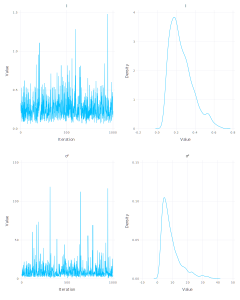

In [280]:
ps = Array{Gadfly.Plot}(2,2)
p = plot(c1)

k = [1,3]
for i = 1:2
    ps[i,1] = p[1,k[i]]
    ps[i,2] = p[2,k[i]]
end

gridstack(ps)

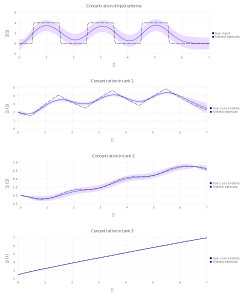

In [283]:
l,σ² = [median(c.value[:,i,1]) for i ∈ k]

θ = default_params()
θ["Kernel Parameters"] = (√3 / l, l, σ²)

f, P, _, _, G = infer(t, 𝐲, t[ix], 𝛉=θ, rts=:true, gain=:true)

display(plot_estimate(f, P, t, 𝛉=default_params()))

In [285]:
c2 = sample(clfm_unknown_rate(𝐲), PG(25, 1000))

[Turing]:  Assume - `l` is a parameter (ignoring `l` found in global scope)
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `σ²` is a parameter (ignoring `σ²` found in global scope)
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `a₁` is a parameter (ignoring `a₁` found in global scope)
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `a₂` is a parameter (ignoring `a₂` found in global scope)
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `a₃` is a parameter (ignoring `a₃` found in global scope)
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Observe - `y` is an observation
 @~(::ANY, ::ANY) at compiler.jl:57


[PG] Sampling...100%  ETA: 0:00:01

Object of type "Turing.Chain"

Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

[0.192031 0.169706 … 0.0 0.717229; 0.192031 0.169706 … 0.0 0.572759; … ; 0.286063 0.16622 … 0.0 0.359379; 0.286063 0.16622 … 0.0 0.526655]

[PG] Finished with
  Running time    = 490.50366938299965;


[PG] Sampling...100% Time: 0:08:11


In [286]:
describe(c2)

Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

Empirical Posterior Estimates:
           Mean         SD         Naive SE        MCSE         ESS   
      l 0.33237276 0.1276435519 0.004036443527 0.0336775861  14.365338
     a₃ 0.16760435 0.0013422278 0.000042444970 0.0002437262  30.328296
     a₁ 0.62281331 0.5777990436 0.018271610075 0.1249886595  21.370388
     a₂ 0.24115753 0.0130645090 0.000413136048 0.0032714684  15.947798
     σ² 3.69387588 1.3053247318 0.041277992386 0.3877319522  11.333758
     lp 0.00000000 0.0000000000 0.000000000000 0.0000000000        NaN
elapsed 0.49050367 0.0746209121 0.002359720432 0.0026751891 778.058260

Quantiles:
           2.5%       25.0%      50.0%      75.0%      97.5%  
      l 0.20286726 0.21267615 0.28606331 0.44080992 0.71701280
     a₃ 0.16422821 0.16743239 0.16775383 0.16830443 0.17115421
     a₁ 0.26643650 0.44798940 0.49570297 0.61637791 3.38699679
     a₂ 0.22552163 0.22901967 0.24917800 0.25109443 0.2525

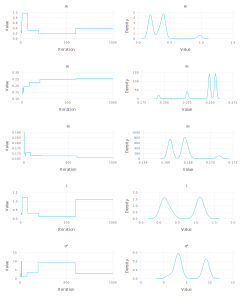

In [287]:
ps = Array{Gadfly.Plot}(5,2)
p = plot(c)

k = [3,4,2,1,5]
for i = 1:5
    ps[i,1] = p[1,k[i]]
    ps[i,2] = p[2,k[i]]
end

gridstack(ps)

In [290]:
a₁,a₂,a₃,l,σ² = [mean(c2.value[:,i,1]) for i = 1:7][k]

5-element Array{Float64,1}:
 0.622813
 0.241158
 0.167604
 0.332373
 3.69388 

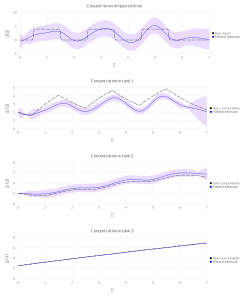

In [291]:
θ = default_params()
θ["Output Rates"] = (-a₁,-a₂,-a₃)
θ["Kernel Parameters"] = (√3 / l, l, σ²)

f, P, _, _, G = infer(t, 𝐲, t[ix], 𝛉=θ, rts=:true, gain=:true)

display(plot_estimate(f, P, t, 𝛉=default_params()))